In [16]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM

In [17]:
# Importing dataset
dataset = pd.read_csv('cases_four_states.csv')

In [125]:
# Defining test set
test_set_f = np.array(dataset.iloc[-16:310, 0:1])
print(test_set_f)

[[ 7464]
 [ 6927]
 [ 6893]
 [ 9875]
 [10968]
 [ 9890]
 [ 8743]
 [ 9811]
 [11478]
 [13005]
 [15442]
 [14319]
 [ 8337]
 [15329]
 [18350]
 [14640]]


In [19]:
print(dataset)

           date  CALIFORNIA  ILLINOIS  MISSOURI  WASHINGTON
0     1/22/2020           0         0         0           1
1     1/23/2020           0         0         0           0
2     1/24/2020           0         1         0           0
3     1/25/2020           0         0         0           0
4     1/26/2020           2         0         0           0
..          ...         ...       ...       ...         ...
305  11/22/2020       14319     10012         0           0
306  11/23/2020        8337      8322      3370        6277
307  11/24/2020       15329      9469      3764        3482
308  11/25/2020       18350     11378      4131        2887
309  11/26/2020       14640     12022      4471           0

[310 rows x 5 columns]


In [20]:
# Testing for stationary and non-stationary 
from statsmodels.tsa.stattools import adfuller

dftest = adfuller(dataset['CALIFORNIA'], autolag = 'AIC')

print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  0.19670623960858968
2. P-Value :  0.97207625070814
3. Num Of Lags :  9
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 300
5. Critical Values :
	 1% :  -3.4523371197407404
	 5% :  -2.871222860740741
	 10% :  -2.571929211111111


#We can interpret above results based on p-values of result.

#p-value > 0.05 - This implies that time-series is non-stationary.
#p-value <=0.05 - This implies that time-series is stationary.
#We can see from the above results that p-value is greater than 0.05 hence our time-series is not stationary. It still has time-dependent components present which we need to remove.

In [21]:
# making date as pandas date and setting as a index
dataset['date'] = pd.to_datetime(dataset['date'])
dataset.set_index('date', inplace=True)

In [22]:
# Removing seasonality and trend

# 1- Removing seasonality
import copy
order = 2
coef = np.polyfit(np.arange(len(dataset['CALIFORNIA'])),
                  dataset['CALIFORNIA'].values.ravel(),
                  order)
poly_mdl = np.poly1d(coef)
poly_mdl
trend = pd.Series(data = poly_mdl(np.arange(len(dataset['CALIFORNIA']))),
                  index = dataset.index)
detrended = dataset['CALIFORNIA'] - trend
seasonal = detrended.groupby(by = detrended.index.month).mean()
col = 'CALIFORNIA'
seasonal_component = copy.deepcopy(dataset)
for i in seasonal.index:
    seasonal_component.loc[seasonal_component.index.month == i, col] = seasonal.loc[i]
deseasonal = dataset - seasonal_component

# 2- Removing trend
coef = np.polyfit(np.arange(len(deseasonal)), deseasonal['CALIFORNIA'], order)
poly_mdl = np.poly1d(coef)
trend_comp = pd.DataFrame(data = poly_mdl(np.arange(len(dataset['CALIFORNIA']))),
                          index = dataset.index,
                          columns=['CALIFORNIA'])

# Remaining 
residual = dataset - seasonal_component - trend_comp

In [23]:
# Seasonality and trend of test set
trend_comp_test = trend_comp.iloc[-16:310, :]
seasonal_component_test = seasonal_component.iloc[-16:310, :]
print(trend_comp_test.shape)

(16, 1)


In [26]:
# Defining training and testing dataset based on residuals
training_data = residual.iloc[:, 0:1].values

In [127]:
print(training_data.shape)

(310, 1)


In [28]:
# Defining traning set and test set
num_data = len(training_data)
train_split = 0.95
num_train = int(train_split * num_data)
num_test = num_data - num_train
training_set = training_data[0:num_train]
test_set = training_data[num_train:]


In [29]:
print(training_set.shape)
print(test_set.shape)

(294, 1)
(16, 1)


In [30]:
#scaling 
sc = MinMaxScaler(feature_range = (0,1))
training_set_scaled = sc.fit_transform(training_set)

In [31]:
#creating sequence length 
# For this problem, the model is trained based on data from last 14 days to predict the next day.
x_train = []
y_train = []
for i in range(14, 294):
    x_train.append(training_set_scaled[i-14:i, 0:1])
    y_train.append(training_set_scaled[i, 0:1])
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],x_train.shape[2]))

In [32]:
print(x_train.shape)
print(y_train.shape)

(280, 14, 1)
(280, 1)


In [129]:
regressor = Sequential()

In [130]:
regressor.add(LSTM(units =50, return_sequences=True, input_shape=(x_train.shape[1],x_train.shape[2])))
regressor.add(Dropout(0.2))

In [131]:
regressor.add(LSTM(units =50, return_sequences=True))
regressor.add(Dropout(0.2))

In [132]:
regressor.add(LSTM(units =50))
regressor.add(Dropout(0.2))

In [133]:
regressor.add(Dense(units=1))
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

In [134]:
regressor.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 14, 50)            10400     
_________________________________________________________________
dropout_20 (Dropout)         (None, 14, 50)            0         
_________________________________________________________________
lstm_24 (LSTM)               (None, 14, 50)            20200     
_________________________________________________________________
dropout_21 (Dropout)         (None, 14, 50)            0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dropout_22 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)               

In [135]:
history = regressor.fit(x_train, y_train, epochs = 2000, batch_size = 20 , validation_split=0.33 )

Epoch 1/2000
10/10 [==============================] - 1s 85ms/step - loss: 0.1142 - val_loss: 0.0610
Epoch 2/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0238 - val_loss: 0.0340
Epoch 3/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0170 - val_loss: 0.0333
Epoch 4/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0133 - val_loss: 0.0301
Epoch 5/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0124 - val_loss: 0.0305
Epoch 6/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0116 - val_loss: 0.0312
Epoch 7/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0115 - val_loss: 0.0299
Epoch 8/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0126 - val_loss: 0.0298
Epoch 9/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0118 - val_loss: 0.0306
Epoch 10/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0106 - val_lo

10/10 [==============================] - 0s 13ms/step - loss: 0.0094 - val_loss: 0.0304
Epoch 82/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0097 - val_loss: 0.0281
Epoch 83/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0097 - val_loss: 0.0319
Epoch 84/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0095 - val_loss: 0.0298
Epoch 85/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0085 - val_loss: 0.0287
Epoch 86/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0092 - val_loss: 0.0302
Epoch 87/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0097 - val_loss: 0.0295
Epoch 88/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0094 - val_loss: 0.0281
Epoch 89/2000
10/10 [==============================] - 0s 12ms/step - loss: 0.0098 - val_loss: 0.0294
Epoch 90/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0090 - val_loss: 0

Epoch 161/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0090 - val_loss: 0.0270
Epoch 162/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0087 - val_loss: 0.0265
Epoch 163/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0087 - val_loss: 0.0263
Epoch 164/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0086 - val_loss: 0.0284
Epoch 165/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0085 - val_loss: 0.0253
Epoch 166/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0082 - val_loss: 0.0288
Epoch 167/2000
10/10 [==============================] - 0s 14ms/step - loss: 0.0096 - val_loss: 0.0277
Epoch 168/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0086 - val_loss: 0.0256
Epoch 169/2000
10/10 [==============================] - 0s 13ms/step - loss: 0.0086 - val_loss: 0.0276
Epoch 170/2000
10/10 [==============================] - 0s 13ms/step - lo

10/10 [==============================] - 0s 16ms/step - loss: 0.0074 - val_loss: 0.0292
Epoch 241/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0081 - val_loss: 0.0314
Epoch 242/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0092 - val_loss: 0.0339
Epoch 243/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0081 - val_loss: 0.0306
Epoch 244/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0077 - val_loss: 0.0284
Epoch 245/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0082 - val_loss: 0.0308
Epoch 246/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0081 - val_loss: 0.0311
Epoch 247/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0074 - val_loss: 0.0329
Epoch 248/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0078 - val_loss: 0.0320
Epoch 249/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0080 - va

10/10 [==============================] - 0s 16ms/step - loss: 0.0073 - val_loss: 0.0412
Epoch 320/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0074 - val_loss: 0.0452
Epoch 321/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0075 - val_loss: 0.0464
Epoch 322/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0072 - val_loss: 0.0488
Epoch 323/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0069 - val_loss: 0.0415
Epoch 324/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0066 - val_loss: 0.0507
Epoch 325/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0077 - val_loss: 0.0400
Epoch 326/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0078 - val_loss: 0.0335
Epoch 327/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0067 - val_loss: 0.0341
Epoch 328/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0072 - va

10/10 [==============================] - 0s 16ms/step - loss: 0.0062 - val_loss: 0.0541
Epoch 399/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0067 - val_loss: 0.0612
Epoch 400/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0060 - val_loss: 0.0575
Epoch 401/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0069 - val_loss: 0.0495
Epoch 402/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0061 - val_loss: 0.0483
Epoch 403/2000
10/10 [==============================] - 0s 15ms/step - loss: 0.0065 - val_loss: 0.0495
Epoch 404/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0060 - val_loss: 0.0489
Epoch 405/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0.0513
Epoch 406/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0067 - val_loss: 0.0536
Epoch 407/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0068 - va

10/10 [==============================] - 0s 17ms/step - loss: 0.0058 - val_loss: 0.0501
Epoch 478/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0064 - val_loss: 0.0497
Epoch 479/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0061 - val_loss: 0.0488
Epoch 480/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0064 - val_loss: 0.0442
Epoch 481/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0062 - val_loss: 0.0436
Epoch 482/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0060 - val_loss: 0.0467
Epoch 483/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0060 - val_loss: 0.0496
Epoch 484/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0058 - val_loss: 0.0468
Epoch 485/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0057 - val_loss: 0.0504
Epoch 486/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0062 - va

10/10 [==============================] - 0s 16ms/step - loss: 0.0052 - val_loss: 0.0402
Epoch 557/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0053 - val_loss: 0.0382
Epoch 558/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0058 - val_loss: 0.0423
Epoch 559/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0057 - val_loss: 0.0401
Epoch 560/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0051 - val_loss: 0.0406
Epoch 561/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0049 - val_loss: 0.0422
Epoch 562/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0053 - val_loss: 0.0393
Epoch 563/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0048 - val_loss: 0.0388
Epoch 564/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0052 - val_loss: 0.0425
Epoch 565/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0053 - va

10/10 [==============================] - 0s 16ms/step - loss: 0.0048 - val_loss: 0.0433
Epoch 636/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0045 - val_loss: 0.0394
Epoch 637/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0048 - val_loss: 0.0444
Epoch 638/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0046 - val_loss: 0.0441
Epoch 639/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0049 - val_loss: 0.0418
Epoch 640/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0050 - val_loss: 0.0476
Epoch 641/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0046 - val_loss: 0.0433
Epoch 642/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0054 - val_loss: 0.0436
Epoch 643/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0043 - val_loss: 0.0450
Epoch 644/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0044 - va

10/10 [==============================] - 0s 16ms/step - loss: 0.0042 - val_loss: 0.0486
Epoch 715/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0042 - val_loss: 0.0523
Epoch 716/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0047 - val_loss: 0.0491
Epoch 717/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0046 - val_loss: 0.0505
Epoch 718/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0041 - val_loss: 0.0499
Epoch 719/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0040 - val_loss: 0.0463
Epoch 720/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0040 - val_loss: 0.0491
Epoch 721/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0040 - val_loss: 0.0499
Epoch 722/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0040 - val_loss: 0.0490
Epoch 723/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0039 - va

10/10 [==============================] - 0s 16ms/step - loss: 0.0035 - val_loss: 0.0503
Epoch 794/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0042 - val_loss: 0.0495
Epoch 795/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0039 - val_loss: 0.0509
Epoch 796/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0040 - val_loss: 0.0556
Epoch 797/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0042 - val_loss: 0.0540
Epoch 798/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0036 - val_loss: 0.0506
Epoch 799/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0039 - val_loss: 0.0455
Epoch 800/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0045 - val_loss: 0.0474
Epoch 801/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0039 - val_loss: 0.0468
Epoch 802/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0041 - va

10/10 [==============================] - 0s 17ms/step - loss: 0.0036 - val_loss: 0.0453
Epoch 873/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0033 - val_loss: 0.0505
Epoch 874/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0041 - val_loss: 0.0465
Epoch 875/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0037 - val_loss: 0.0461
Epoch 876/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0043 - val_loss: 0.0487
Epoch 877/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0048 - val_loss: 0.0427
Epoch 878/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0043 - val_loss: 0.0429
Epoch 879/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0035 - val_loss: 0.0479
Epoch 880/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0036 - val_loss: 0.0534
Epoch 881/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0032 - va

10/10 [==============================] - 0s 19ms/step - loss: 0.0025 - val_loss: 0.0493
Epoch 952/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0025 - val_loss: 0.0505
Epoch 953/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0027 - val_loss: 0.0511
Epoch 954/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0024 - val_loss: 0.0485
Epoch 955/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0025 - val_loss: 0.0451
Epoch 956/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0025 - val_loss: 0.0489
Epoch 957/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0030 - val_loss: 0.0470
Epoch 958/2000
10/10 [==============================] - 0s 20ms/step - loss: 0.0027 - val_loss: 0.0477
Epoch 959/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.0024 - val_loss: 0.0516
Epoch 960/2000
10/10 [==============================] - 0s 21ms/step - loss: 0.0024 - va

10/10 [==============================] - 0s 17ms/step - loss: 0.0021 - val_loss: 0.0503
Epoch 1031/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0023 - val_loss: 0.0502
Epoch 1032/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.0031 - val_loss: 0.0437
Epoch 1033/2000
10/10 [==============================] - 0s 24ms/step - loss: 0.0024 - val_loss: 0.0456
Epoch 1034/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0022 - val_loss: 0.0453
Epoch 1035/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0021 - val_loss: 0.0472
Epoch 1036/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0022 - val_loss: 0.0475
Epoch 1037/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0019 - val_loss: 0.0484
Epoch 1038/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0023 - val_loss: 0.0449
Epoch 1039/2000
10/10 [==============================] - 0s 19ms/step - loss: 0.

Epoch 1109/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0024 - val_loss: 0.0452
Epoch 1110/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0023 - val_loss: 0.0501
Epoch 1111/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0025 - val_loss: 0.0482
Epoch 1112/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 0.0488
Epoch 1113/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0020 - val_loss: 0.0465
Epoch 1114/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0479
Epoch 1115/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0021 - val_loss: 0.0478
Epoch 1116/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0025 - val_loss: 0.0477
Epoch 1117/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0022 - val_loss: 0.0484
Epoch 1118/2000
10/10 [==============================] - 0s 17ms

10/10 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0496
Epoch 1188/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0020 - val_loss: 0.0500
Epoch 1189/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0022 - val_loss: 0.0485
Epoch 1190/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0021 - val_loss: 0.0432
Epoch 1191/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0019 - val_loss: 0.0455
Epoch 1192/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0480
Epoch 1193/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0484
Epoch 1194/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0500
Epoch 1195/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 0.0483
Epoch 1196/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.

Epoch 1266/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0476
Epoch 1267/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0468
Epoch 1268/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0449
Epoch 1269/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0482
Epoch 1270/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0489
Epoch 1271/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0472
Epoch 1272/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0456
Epoch 1273/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0014 - val_loss: 0.0467
Epoch 1274/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0452
Epoch 1275/2000
10/10 [==============================] - 0s 17ms

10/10 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0435
Epoch 1345/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0413
Epoch 1346/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0416
Epoch 1347/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0413
Epoch 1348/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0434
Epoch 1349/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0428
Epoch 1350/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 0.0394
Epoch 1351/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0014 - val_loss: 0.0482
Epoch 1352/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0422
Epoch 1353/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.

Epoch 1423/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0391
Epoch 1424/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0409
Epoch 1425/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0422
Epoch 1426/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0418
Epoch 1427/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0416
Epoch 1428/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0427
Epoch 1429/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0406
Epoch 1430/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0404
Epoch 1431/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0405
Epoch 1432/2000
10/10 [==============================] - 0s 17ms

10/10 [==============================] - 0s 17ms/step - loss: 9.7962e-04 - val_loss: 0.0411
Epoch 1502/2000
10/10 [==============================] - 0s 17ms/step - loss: 9.1238e-04 - val_loss: 0.0425
Epoch 1503/2000
10/10 [==============================] - 0s 17ms/step - loss: 9.4375e-04 - val_loss: 0.0393
Epoch 1504/2000
10/10 [==============================] - 0s 17ms/step - loss: 9.5724e-04 - val_loss: 0.0405
Epoch 1505/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0010 - val_loss: 0.0432
Epoch 1506/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0010 - val_loss: 0.0397
Epoch 1507/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0417
Epoch 1508/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0412
Epoch 1509/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0011 - val_loss: 0.0406
Epoch 1510/2000
10/10 [==============================] - 0s 17ms

10/10 [==============================] - 0s 17ms/step - loss: 9.7898e-04 - val_loss: 0.0423
Epoch 1579/2000
10/10 [==============================] - 0s 17ms/step - loss: 8.8147e-04 - val_loss: 0.0426e-
Epoch 1580/2000
10/10 [==============================] - 0s 17ms/step - loss: 9.1441e-04 - val_loss: 0.0406
Epoch 1581/2000
10/10 [==============================] - 0s 17ms/step - loss: 7.0372e-04 - val_loss: 0.0411
Epoch 1582/2000
10/10 [==============================] - 0s 17ms/step - loss: 8.4209e-04 - val_loss: 0.0418
Epoch 1583/2000
10/10 [==============================] - 0s 17ms/step - loss: 9.4987e-04 - val_loss: 0.0415
Epoch 1584/2000
10/10 [==============================] - 0s 16ms/step - loss: 8.9023e-04 - val_loss: 0.0434
Epoch 1585/2000
10/10 [==============================] - 0s 17ms/step - loss: 9.2886e-04 - val_loss: 0.0383
Epoch 1586/2000
10/10 [==============================] - 0s 17ms/step - loss: 9.3763e-04 - val_loss: 0.0403
Epoch 1587/2000
10/10 [===================

10/10 [==============================] - 0s 17ms/step - loss: 0.0092 - val_loss: 0.0354
Epoch 1655/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0070 - val_loss: 0.0283
Epoch 1656/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0070 - val_loss: 0.0297
Epoch 1657/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0067 - val_loss: 0.0328
Epoch 1658/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0057 - val_loss: 0.0374
Epoch 1659/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0058 - val_loss: 0.0376
Epoch 1660/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0053 - val_loss: 0.0439
Epoch 1661/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0057 - val_loss: 0.0419
Epoch 1662/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0053 - val_loss: 0.0428
Epoch 1663/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.

Epoch 1733/2000
10/10 [==============================] - 0s 16ms/step - loss: 0.0021 - val_loss: 0.0504
Epoch 1734/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0021 - val_loss: 0.0442
Epoch 1735/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0442
Epoch 1736/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0467
Epoch 1737/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0014 - val_loss: 0.0474
Epoch 1738/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0016 - val_loss: 0.0450
Epoch 1739/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0017 - val_loss: 0.0456
Epoch 1740/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0015 - val_loss: 0.0465
Epoch 1741/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0018 - val_loss: 0.0457
Epoch 1742/2000
10/10 [==============================] - 0s 17ms

10/10 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0489
Epoch 1812/2000
10/10 [==============================] - 0s 18ms/step - loss: 0.0012 - val_loss: 0.0462
Epoch 1813/2000
10/10 [==============================] - 0s 17ms/step - loss: 9.6180e-04 - val_loss: 0.0469
Epoch 1814/2000
10/10 [==============================] - 0s 17ms/step - loss: 9.0507e-04 - val_loss: 0.0458
Epoch 1815/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0468
Epoch 1816/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0496
Epoch 1817/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0469
Epoch 1818/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0013 - val_loss: 0.0475
Epoch 1819/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0012 - val_loss: 0.0456
Epoch 1820/2000
10/10 [==============================] - 0s 17ms/step - 

10/10 [==============================] - 0s 17ms/step - loss: 9.3308e-04 - val_loss: 0.0464
Epoch 1889/2000
10/10 [==============================] - 0s 16ms/step - loss: 9.9255e-04 - val_loss: 0.0464
Epoch 1890/2000
10/10 [==============================] - 0s 17ms/step - loss: 9.8040e-04 - val_loss: 0.0468
Epoch 1891/2000
10/10 [==============================] - 0s 17ms/step - loss: 9.8193e-04 - val_loss: 0.0491
Epoch 1892/2000
10/10 [==============================] - 0s 16ms/step - loss: 9.1221e-04 - val_loss: 0.0466
Epoch 1893/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0446
Epoch 1894/2000
10/10 [==============================] - ETA: 0s - loss: 9.7322e-0 - 0s 17ms/step - loss: 9.6555e-04 - val_loss: 0.0479
Epoch 1895/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0011 - val_loss: 0.0459
Epoch 1896/2000
10/10 [==============================] - 0s 17ms/step - loss: 9.9248e-04 - val_loss: 0.0474
Epoch 1897/2000
10/10 [=

10/10 [==============================] - 0s 17ms/step - loss: 0.0025 - val_loss: 0.0426
Epoch 1965/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0024 - val_loss: 0.0414
Epoch 1966/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0026 - val_loss: 0.0433
Epoch 1967/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0029 - val_loss: 0.0386
Epoch 1968/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0023 - val_loss: 0.0401
Epoch 1969/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0024 - val_loss: 0.0411
Epoch 1970/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0025 - val_loss: 0.0377
Epoch 1971/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0021 - val_loss: 0.0444
Epoch 1972/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.0025 - val_loss: 0.0420
Epoch 1973/2000
10/10 [==============================] - 0s 17ms/step - loss: 0.

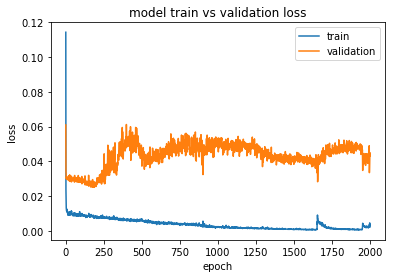

In [136]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'])
pyplot.plot(history.history['val_loss'])
pyplot.title('model train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [137]:
# Building the test data
dataset_total = training_data
inputs = dataset_total[len(dataset_total)- len(test_set)-14:]
inputs= np.reshape(inputs, (inputs.shape[0], inputs.shape[1]))
inputs = sc.transform(inputs)
x_test = []
for i in range(14, 30):
    x_test.append(inputs[i-14:i, 0:1])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],x_test.shape[2]))

In [138]:
print(x_test.shape)

(16, 14, 1)


In [139]:
# Predicting and reversing the data
predicted_set = regressor.predict(x_test)
predicted_set = sc.inverse_transform(predicted_set)


In [140]:
# Adding seasonality and trend to predicted set
predicted_set_f= []
trend_comp_test = np.array(trend_comp_test)
seasonal_component_test = np.array(seasonal_component_test)
predicted_set_f = np.array([[predicted_set[i][j] + trend_comp_test[i][j] + seasonal_component_test[i][j] 
                    for j in range (len(predicted_set[0]))] for i in range(len(predicted_set))])


In [141]:
# Exporting the data to calculate MAPE
test_dataframe = pd.DataFrame(test_set_f)  
predict_dataframe = pd.DataFrame((predicted_set_f))
test_dataframe.to_csv(r'C:\Users\mdavahli\Desktop\twitter\test.csv')
predict_dataframe.to_csv(r'C:\Users\mdavahli\Desktop\twitter\predict.csv')